# Preparations

### you might need to install this

In [1]:
# !pip install wordcloud

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

videosUS = pd.read_csv('US_youtube_trending_data.csv')
videosUK = pd.read_csv('GB_youtube_trending_data.csv')

In [3]:
categDict = {"1":"Film & Animation","2":"Autos & Vehicles","10":"Music","15":"Pets & Animals","17":"Sports",
             "18":"Short Movies","19":"Travel & Events","20":"Gaming","21":"Videoblogging","22":"People & Blogs",
             "23":"Comedy","24":"Entertainment","25":"News & Politics","26":"Howto & Style","27":"Education",
             "28":"Science & Technology","29":"Nonprofits & Activism","30":"Movies","31":"Anime/Animation",
             "32":"Action/Adventure","33":"Classics","34":"Comedy","35":"Documentary","36":"Drama","37":"Family",
             "38":"Foreign","39":"Horror","40":"Sci-Fi/Fantasy","41":"Thriller","42":"Shorts","43":"Shows","44":"Trailers"}

In [4]:
def create_nodupl(df):
    latest_data = df.sort_values(by=["video_id", "trending_date"], ascending=[True, False]).drop_duplicates(subset="video_id")
    trending_days = df["video_id"].value_counts()
    latest_data["trending_days"] = latest_data["video_id"].map(trending_days)
    latest_data = latest_data.drop(columns=["trending_date"])
    
    return latest_data

noduplUS = create_nodupl(videosUS)
noduplUK = create_nodupl(videosUK)

In [5]:
#noduplUS.head()

In [6]:
def calculate_category_percentages(nodupl_df):
    total_videos = len(nodupl_df)
    category_counts = nodupl_df["categoryId"].value_counts()
    category_percentages = (category_counts / total_videos) * 100
    return category_percentages

In [7]:
#print(calculate_category_percentages(noduplUS))
#print()
#print(calculate_category_percentages(noduplUK))

In [8]:
# PLOT CATEGORIES OF A VIDEO
def plot_category_pie(percentages, title):
    # Map category IDs to names
    color_map = {
        cat_id: color
        for cat_id, color in zip(categDict.keys(), plt.cm.tab20b.colors[:len(categDict)])
    }
    category_names = percentages.index.map(lambda x: categDict.get(str(x), f"Category {x}"))
    category_percentages = percentages.values
    category_colors = [color_map[str(cat_id)] for cat_id in percentages.index]

    # Pie chart
    fig, ax = plt.subplots(figsize=(10, 6))
    wedges, texts, autotexts = ax.pie(
        category_percentages, 
        labels=None, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=category_colors,
        counterclock=False
    )

    # Legend with category names
    legend_labels = [f"{name} - {pct:.2f}%" for name, pct in zip(category_names, category_percentages)]
    ax.legend(
        wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5),
        fontsize=10, title="Categories"
    )

    ax.set_title(title)
    plt.show()


# COUNT AND LIST CHANNELS IN A DATAFRAME
def unique_channels_count(df):
    unique_channels = df["channelId"].unique().tolist()
    count = len(unique_channels)
    return unique_channels, count

# COMPARING CATEGORIES (their distribution)

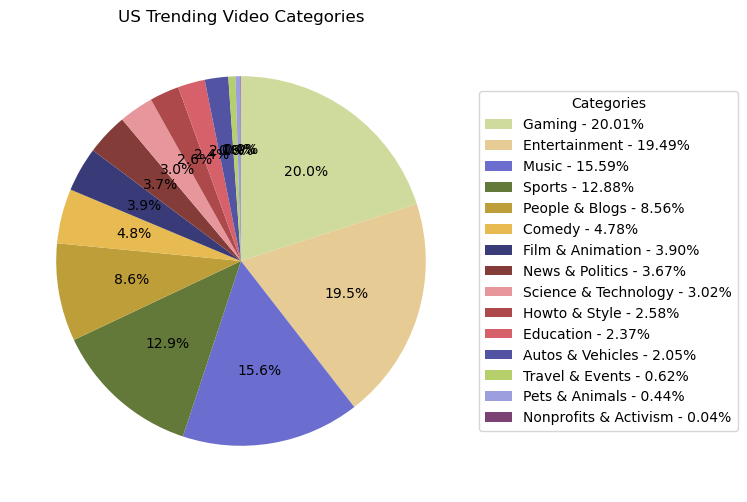

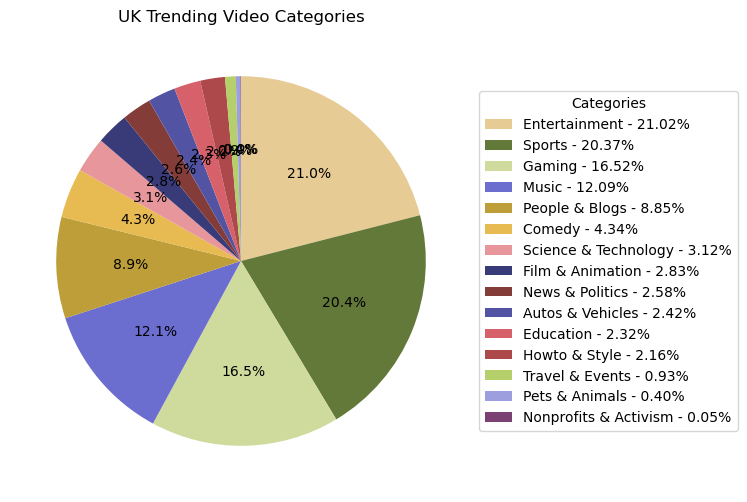

In [9]:
# Saving these two as variables
us_category_percentages = calculate_category_percentages(noduplUS)
uk_category_percentages = calculate_category_percentages(noduplUK)

plot_category_pie(us_category_percentages, "US Trending Video Categories")
plot_category_pie(uk_category_percentages, "UK Trending Video Categories")

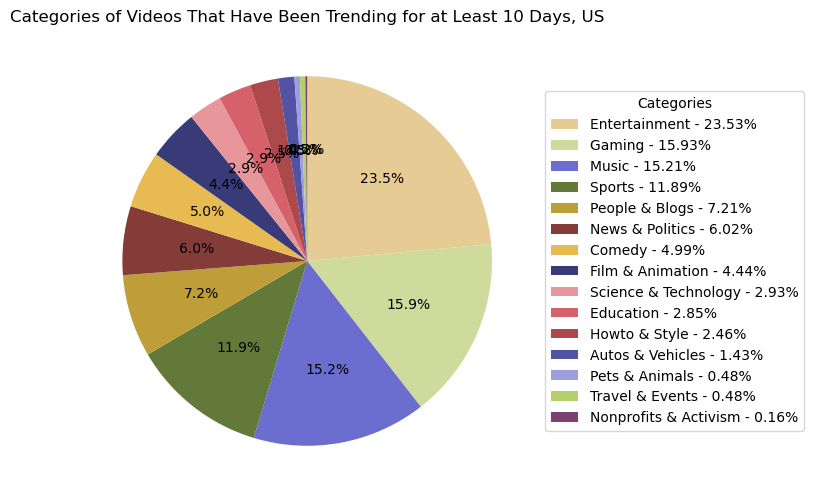

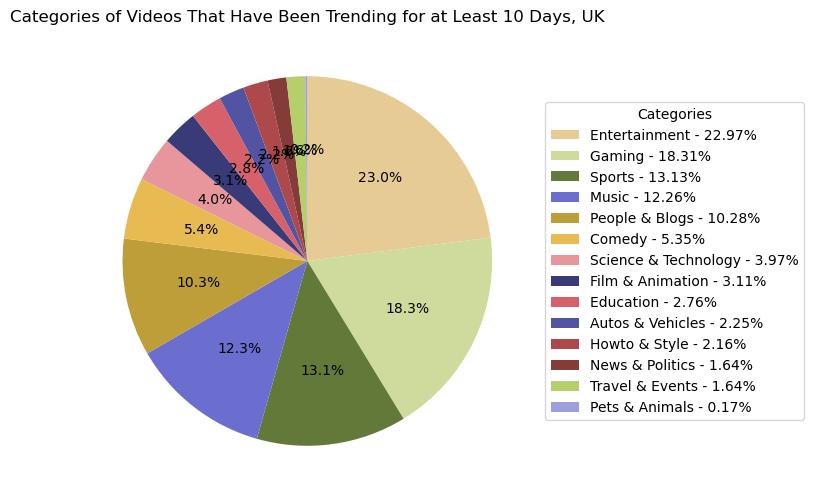

In [40]:
plot_category_pie(calculate_category_percentages(noduplUS[noduplUS['trending_days'] >= 10]),
                  "Categories of Videos That Have Been Trending for at Least 10 Days, US")
plot_category_pie(calculate_category_percentages(noduplUK[noduplUK['trending_days'] >= 10]),
                  "Categories of Videos That Have Been Trending for at Least 10 Days, UK")

In [10]:
# By "common" I mean those that were trending in both US and UK
common_videos = pd.merge(noduplUS, noduplUK, on="video_id", how="inner", suffixes=("_US", "_UK"))

# Get the list and count of common videos
common_video_list = common_videos["video_id"].tolist()
common_video_count = len(common_video_list)

print(f"Number of videos trending in both countries: {common_video_count}")
print(f"... which accounts for {100 * common_video_count / noduplUS.shape[0]}% of total videos trending in the US")
print(f"... and {100 * common_video_count / noduplUK.shape[0]}% in the UK")

Number of videos trending in both countries: 24447
... which accounts for 51.85821560392007% of total videos trending in the US
... and 51.35169197807045% in the UK


# COMPARING MOST POPULAR CHANNELS

In [11]:
common_channels = pd.merge(noduplUS, noduplUK, on="channelId", how="inner", suffixes=("_US", "_UK"))
us_channels, us_channel_count = unique_channels_count(noduplUS)
uk_channels, uk_channel_count = unique_channels_count(noduplUK)

# Get the list and count of common channels
common_channel_list = common_channels["channelId"].unique().tolist()
common_channel_count = len(common_channel_list)

print("Among the trending videos:")
print("TOTAL NUMBER OF PUBLISHING CHANNELS IN THE US".ljust(70), end='')
print(us_channel_count)
print("TOTAL NUMBER OF PUBLISHING CHANNELS IN THE UK".ljust(70), end='')
print(uk_channel_count)
print("NUMBER OF CHANNELS THAT APPEAR IN BOTH".ljust(70), end='')
print(common_channel_count, end='')

Among the trending videos:
TOTAL NUMBER OF PUBLISHING CHANNELS IN THE US                         8294
TOTAL NUMBER OF PUBLISHING CHANNELS IN THE UK                         7566
NUMBER OF CHANNELS THAT APPEAR IN BOTH                                5032

In [12]:
def top_channels_by_video_count(df, top_n=30):
    # Count the number of videos per channel
    channel_counts = df["channelId"].value_counts()

    # Get the top N channels and their counts
    top_channels = channel_counts.head(top_n)

    # Map channel IDs to channel names for better readability
    channel_names = top_channels.index.map(
        lambda cid: df.loc[df["channelId"] == cid, "channelTitle"].iloc[0]
    )
    return top_channels.index.tolist(), channel_names.tolist(), top_channels.values.tolist()


In [13]:
top_us_channels, top_us_names, top_us_counts = top_channels_by_video_count(noduplUS, top_n=70)
top_uk_channels, top_uk_names, top_uk_counts = top_channels_by_video_count(noduplUK, top_n=70)

In [14]:
def make_table(*columns, column_names=None, widths=None):
    if column_names is None:
        column_names = [f"Column {i+1}" for i in range(len(columns))]

    if len(column_names) != len(columns):
        raise ValueError("Number of column names must match the number of columns provided.")
    
    if widths is None:
        # Default width of 20 for each column
        widths = [20] * len(columns)
    
    if len(widths) != len(columns):
        raise ValueError("Number of widths must match the number of columns.")

    # Create header
    header = " | ".join(str(col_name).ljust(width) for col_name, width in zip(column_names, widths))
    print(header)
    print("-" * len(header))

    # Create rows
    rows = zip(*columns)
    for row in rows:
        row_str = " | ".join(str(cell).ljust(width) for cell, width in zip(row, widths))
        print(row_str)

In [15]:
make_table( list(range(1, len(top_us_names)+1 )), top_us_names, top_us_counts, top_uk_names, top_uk_counts,
           column_names=['Rank', 'Channel (US trends)', 'Number of videos',  'Channel (UK trends)', 'Number of videos '],
          widths=[6, 40, 16, 40, 16] )

Rank   | Channel (US trends)                      | Number of videos | Channel (UK trends)                      | Number of videos 
-----------------------------------------------------------------------------------------------------------------------------------
1      | NFL                                      | 422              | Sky Sports Premier League                | 1034            
2      | NBA                                      | 396              | The United Stand                         | 632             
3      | NBC Sports                               | 167              | BT Sport                                 | 536             
4      | CBS Sports Golazo                        | 146              | FORMULA 1                                | 243             
5      | ESPN                                     | 131              | WWE                                      | 216             
6      | SSundee                                  | 128              | MoreSideme

In [46]:
def generate_channel_word_cloud(us_df, uk_df, country="both", n=100):
    # Get the video IDs that trended in US but not in UK
    us_only = us_df[~us_df['video_id'].isin(uk_df['video_id'])]
    # Get the video IDs that trended in UK but not in US
    uk_only = uk_df[~uk_df['video_id'].isin(us_df['video_id'])]
    
    # Filter based on the country argument
    if country == "US":
        # Get channels that trended only in the US
        channel_names = us_only["channelTitle"].value_counts().head(n)
    elif country == "UK":
        # Get channels that trended only in the UK
        channel_names = uk_only["channelTitle"].value_counts().head(n)
    else:
        # Get channels that trended only in the US or only in the UK
        us_channels = us_only["channelTitle"].value_counts()
        uk_channels = uk_only["channelTitle"].value_counts()
        # Combine both lists
        channel_names = us_channels.append(uk_channels).head(n)
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(channel_names.to_dict())

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Channel Names Trending Only in {country.upper()}", fontsize=16)
    plt.show()

In [50]:
def display_top_videos(df, sort_by, top_n=20, country_name="Country"):
    # Sort the dataframe by the specified column
    sorted_df = df.sort_values(by=sort_by, ascending=False).head(top_n)
    
    # Extract relevant columns for the table
    video_ids = sorted_df["video_id"].tolist()
    titles = sorted_df["title"].tolist()
    views = sorted_df["view_count"].tolist()
    likes = sorted_df["likes"].tolist()
    comments = sorted_df["comment_count"].tolist()
    chanName = sorted_df["channelTitle"].tolist()
    categ = sorted_df["categoryId"].tolist()
    categ = [categDict[str(x)] for x in categ]
    days = sorted_df["trending_days"].tolist()

    if country_name == 'US':
        appearing = ['Both' if id in noduplUK["video_id"].tolist() else 'Only US' for id in video_ids ]
    elif country_name == 'UK':
        appearing = ['Both' if id in noduplUS["video_id"].tolist() else 'Only UK' for id in video_ids ]

    # Display using make_table
    print(f"Top {top_n} Videos in {country_name} ranked by {sort_by.capitalize()}")
    make_table( list(range(1,top_n+1)),
        views, 
        likes, 
        chanName, 
        days,
        categ,
        appearing, 
        titles, 
        column_names=["Rank", "Views", "Likes", "Channel", "Days" , "Category", "Appearing" , "Title"],
        widths=[6, 12, 10, 30, 5, 20, 10, 100]
    )

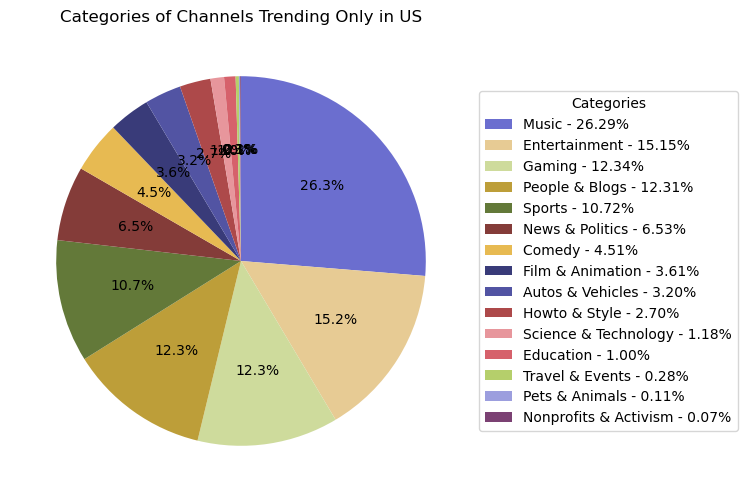

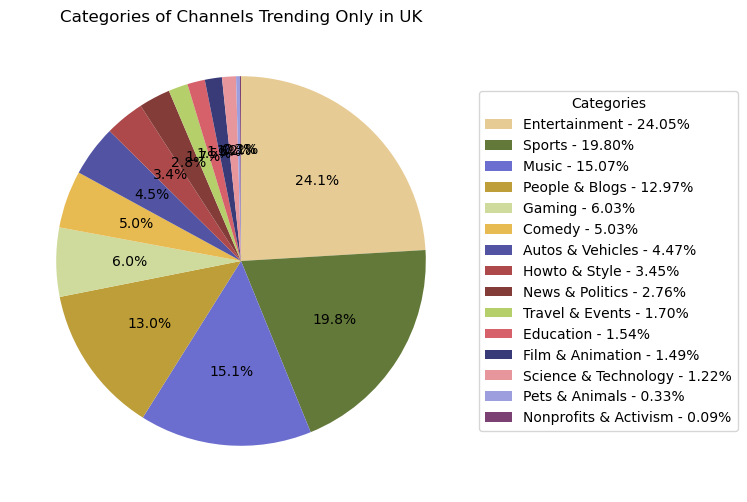


Top Videos by Channels Trending Only in US:
Top 50 Videos in US ranked by Trending_days
Rank   | Views        | Likes      | Channel                        | Days  | Category             | Appearing  | Title                                                                                               
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1      | 508702       | 11008      | Sean Rii                       | 30    | People & Blogs       | Only US    | Sean Rii & Jenieo - Jealousy                                                                        
2      | 1188721      | 47587      | MozzyVEVO                      | 15    | Music                | Only US    | YG, Mozzy - Dangerous (Official Video) ft. G Herbo                                                  
3      | 2709749      | 99824      | Grupo Firme   

In [51]:
# Channels that trended only in US
us_only_channels = set(noduplUS["channelId"]) - set(noduplUK["channelId"])
us_only = noduplUS[noduplUS["channelId"].isin(us_only_channels)]

# Channels that trended only in UK
uk_only_channels = set(noduplUK["channelId"]) - set(noduplUS["channelId"])
uk_only = noduplUK[noduplUK["channelId"].isin(uk_only_channels)]

# Calculate category percentages
us_category_percentages = calculate_category_percentages(us_only)
uk_category_percentages = calculate_category_percentages(uk_only)

# Plot pie charts
plot_category_pie(us_category_percentages, "Categories of Channels Trending Only in US")
plot_category_pie(uk_category_percentages, "Categories of Channels Trending Only in UK")

# Sort by trending days and display using make_table
us_sorted = us_only.sort_values(by="trending_days", ascending=False)
uk_sorted = uk_only.sort_values(by="trending_days", ascending=False)

# Prepare data for make_table
print("\nTop Videos by Channels Trending Only in US:")
display_top_videos(us_sorted, "trending_days", top_n=50, country_name="US")

print("\nTop Videos by Channels Trending Only in UK:")
display_top_videos(uk_sorted, "trending_days", top_n=50, country_name="UK")

## Visualizing channels that tend to trend in one country but not the other

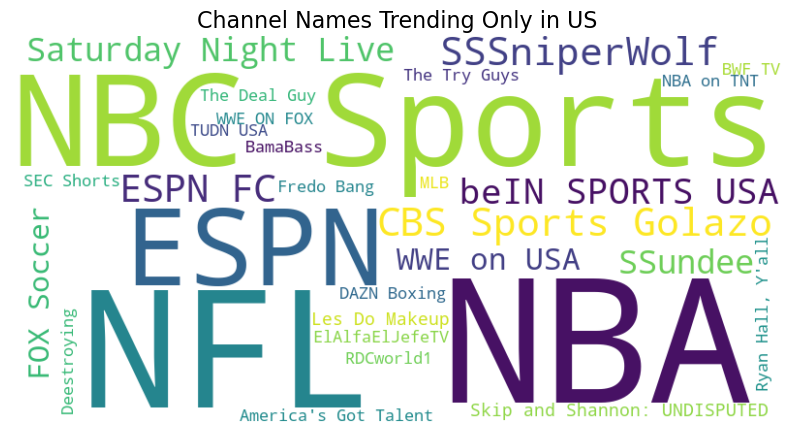

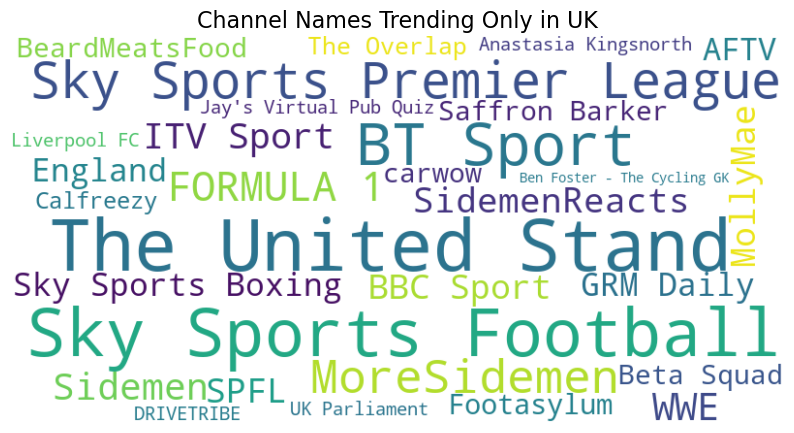

In [17]:
generate_channel_word_cloud(videosUS, videosUK, country="US", n=30)
print('\n\n\n\n')
generate_channel_word_cloud(videosUS, videosUK, country="UK", n=30)

# RANKING VIDEOS BY METRICS (US vs UK)

In [19]:
display_top_videos(noduplUS, "view_count", top_n=50, country_name="US")

Top 50 Videos in US ranked by View_count
Rank   | Views        | Likes      | Channel                | Days  | Category             | Appearing  | Title                                                                                               
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1      | 277791741    | 12993894   | BLACKPINK              | 23    | Music                | Both       | BLACKPINK - ‘Pink Venom’ M/V                                                                        
2      | 264407389    | 16021534   | HYBE LABELS            | 4     | Music                | Both       | BTS (방탄소년단) 'Butter' Official MV                                                                    
3      | 232649205    | 15735533   | Big Hit Labels         | 8     | Music                | Both       | BTS (방탄소년단) 'Dynamite' Of

In [20]:
display_top_videos(noduplUK, "view_count", top_n=50, country_name="UK")

Top 50 Videos in UK ranked by View_count
Rank   | Views        | Likes      | Channel                | Days  | Category             | Appearing  | Title                                                                                               
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1      | 208581468    | 15246514   | Big Hit Labels         | 6     | Music                | Both       | BTS (방탄소년단) 'Dynamite' Official MV                                                                  
2      | 206344829    | 11945462   | BLACKPINK              | 9     | Music                | Both       | BLACKPINK - ‘Pink Venom’ M/V                                                                        
3      | 194625542    | 4935519    | Julius Dein            | 7     | Entertainment        | Only UK    | JETSKI WAX PRANK!! 🤣 - #S

In [21]:
display_top_videos(noduplUS, "likes", top_n=50, country_name="US")
print('\n')
display_top_videos(noduplUK, "likes", top_n=50, country_name="UK")

Top 50 Videos in US ranked by Likes
Rank   | Views        | Likes      | Channel                | Days  | Category             | Appearing  | Title                                                                                               
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1      | 264407389    | 16021534   | HYBE LABELS            | 4     | Music                | Both       | BTS (방탄소년단) 'Butter' Official MV                                                                    
2      | 232649205    | 15735533   | Big Hit Labels         | 8     | Music                | Both       | BTS (방탄소년단) 'Dynamite' Official MV                                                                  
3      | 277791741    | 12993894   | BLACKPINK              | 23    | Music                | Both       | BLACKPINK - ‘Pink Venom’ M/V  

In [22]:
display_top_videos(noduplUS, "trending_days", top_n=50, country_name="US")
print('\n')
display_top_videos(noduplUK, "trending_days", top_n=50, country_name="UK")

Top 50 Videos in US ranked by Trending_days
Rank   | Views        | Likes      | Channel                | Days  | Category             | Appearing  | Title                                                                                               
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1      | 161203338    | 4803077    | MrBeast                | 37    | Entertainment        | Both       | $10,000 Every Day You Survive In A Grocery Store                                                    
2      | 136655670    | 4604685    | MrBeast                | 37    | Entertainment        | Both       | $1 vs $100,000,000 House!                                                                           
3      | 157124797    | 5291129    | MrBeast                | 36    | Entertainment        | Both       | I Survived 7 Days In A

# HOW LONG DOES A VIDEO STAY IN TRENDS? (US vs UK)

In [23]:
def plot_trending_days_histogram(df, title):
    avg_days = df["trending_days"].mean()
    
    plt.figure(figsize=(10, 6))
    plt.hist(
        df["trending_days"], 
        bins=range(1, df["trending_days"].max() + 2), 
        color="skyblue", 
        edgecolor="black", 
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("Number of Days Trending")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Annotate the average
    plt.text(
        0.95, 0.95, 
        f"Avg: {avg_days:.2f} days", 
        horizontalalignment='right', 
        verticalalignment='top', 
        transform=plt.gca().transAxes, 
        fontsize=12, 
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )
    plt.show()

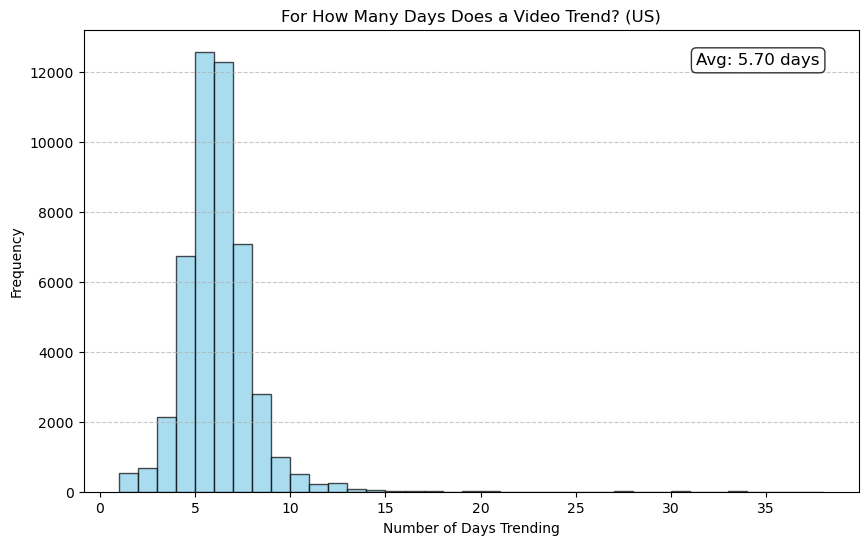

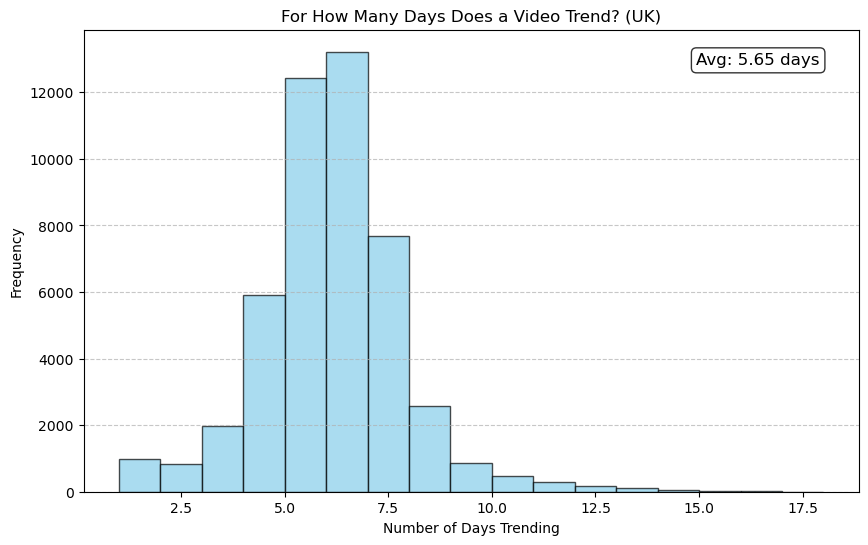

In [24]:
plot_trending_days_histogram(noduplUS, "For How Many Days Does a Video Trend? (US)")
plot_trending_days_histogram(noduplUK, "For How Many Days Does a Video Trend? (UK)")

# COMPARING TAGS

In [54]:
from collections import Counter

# Defining a list of tags to filter out
tags_to_filter_out = {"[none]", "new"}

def get_most_popular_tags(df, n=20, filter_out=tags_to_filter_out):
    all_tags = df["tags"].dropna().str.cat(sep="|").split("|") # splitting by horizontal bars
    all_tags = [x.lower() for x in all_tags if x.lower() not in filter_out] # to lowercase and filtering out unnecessary tags
    tag_counts = Counter(all_tags)  # countint tags
    return tag_counts.most_common(n)

In [55]:
top_us_tags = [[], []]
top_uk_tags = [[], []]

how_many_tags = 50

for tag, count in get_most_popular_tags(noduplUS, n=how_many_tags):
    top_us_tags[0].append(tag)
    top_us_tags[1].append(count)
for tag, count in get_most_popular_tags(noduplUK, n=how_many_tags):
    top_uk_tags[0].append(tag)
    top_uk_tags[1].append(count)

make_table( list(range(1,how_many_tags+1)), top_us_tags[0], top_us_tags[1], top_uk_tags[0], top_uk_tags[1], 
          column_names=['Rank', 'Tag (US)', 'Count (US)', 'Tag (UK)', 'Count (UK)'],
          widths=[20, 33, 16, 33, 10])

Rank                 | Tag (US)                          | Count (US)       | Tag (UK)                          | Count (UK)
----------------------------------------------------------------------------------------------------------------------------
1                    | funny                             | 2974             | football                          | 3482      
2                    | minecraft                         | 2156             | funny                             | 2666      
3                    | comedy                            | 1947             | premier league                    | 2242      
4                    | challenge                         | 1200             | sports                            | 1907      
5                    | nba                               | 1127             | minecraft                         | 1855      
6                    | football                          | 1115             | comedy                            | 1711      


In [29]:
def generate_word_cloud(tags, n=100):
    top_tags = dict(tags[:n])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(top_tags)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide the axes
    plt.title(f"Top {n} Tags", fontsize=16)
    plt.show()

## Visualizing most popular tags in each country

US tags


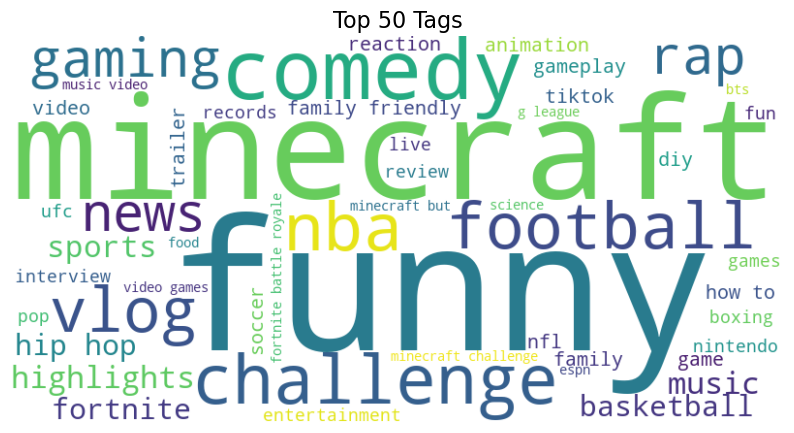





UK tags


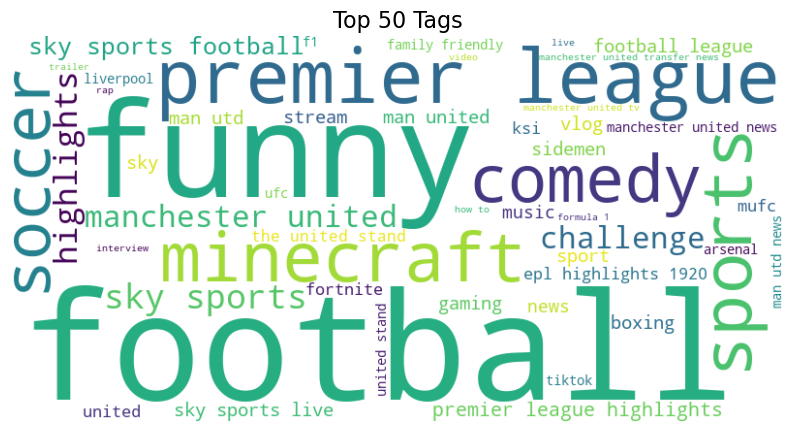

In [56]:
top_us_tags = get_most_popular_tags(noduplUS, n=50)
print('US tags')
generate_word_cloud(top_us_tags, n=50)
print('\n\n\n')
top_uk_tags = get_most_popular_tags(noduplUK, n=50)
print('UK tags')
generate_word_cloud(top_uk_tags, n=50)

In [31]:
def generate_daily_word_clouds(dates, us_df, uk_df, n=20):
    for date in dates:
        # Filter US and UK data for the given date
        us_videos = us_df[us_df["trending_date"].str.startswith(date)]
        uk_videos = uk_df[uk_df["trending_date"].str.startswith(date)]

        # Get the most popular tags for US and UK
        us_tags = get_most_popular_tags(us_videos, n)
        uk_tags = get_most_popular_tags(uk_videos, n)

        # Create a subplot with 1 row and 2 columns for US and UK word clouds
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        
        # US word cloud
        us_wordcloud = WordCloud(width=400, height=400, background_color="white").generate_from_frequencies(dict(us_tags))
        ax[0].imshow(us_wordcloud, interpolation="bilinear")
        ax[0].axis("off")
        ax[0].set_title(f"US Tags - {date}", fontsize=14)
        
        # UK word cloud
        uk_wordcloud = WordCloud(width=400, height=400, background_color="white").generate_from_frequencies(dict(uk_tags))
        ax[1].imshow(uk_wordcloud, interpolation="bilinear")
        ax[1].axis("off")
        ax[1].set_title(f"UK Tags - {date}", fontsize=14)

        # Add the date in the center of the plot
        fig.suptitle(date, fontsize=18, fontweight="bold", y=0.98)

        # Show the word clouds for the day
        plt.show()

In [60]:
#generate_daily_word_clouds(["2022-03-15", "2022-03-16"], videosUS, videosUK, n=20)

# COMPARING TRENDS ON SPECIFIC DAYS

In [59]:
# A method that helps us obtain all the possible dates of videos
def get_unique_dates_in_chronological_order(us_df, uk_df):
    all_dates = pd.concat([us_df['trending_date'], uk_df['trending_date']])
    # Convert the 'trending_date' to datetime format
    all_dates = pd.to_datetime(all_dates)
    # Remove duplicates and sort in chronological order
    unique_dates = sorted(all_dates.dt.date.unique())
    # Convert the dates back to string format (optional, if needed as string)
    unique_dates_str = [str(date) for date in unique_dates]

    return unique_dates_str

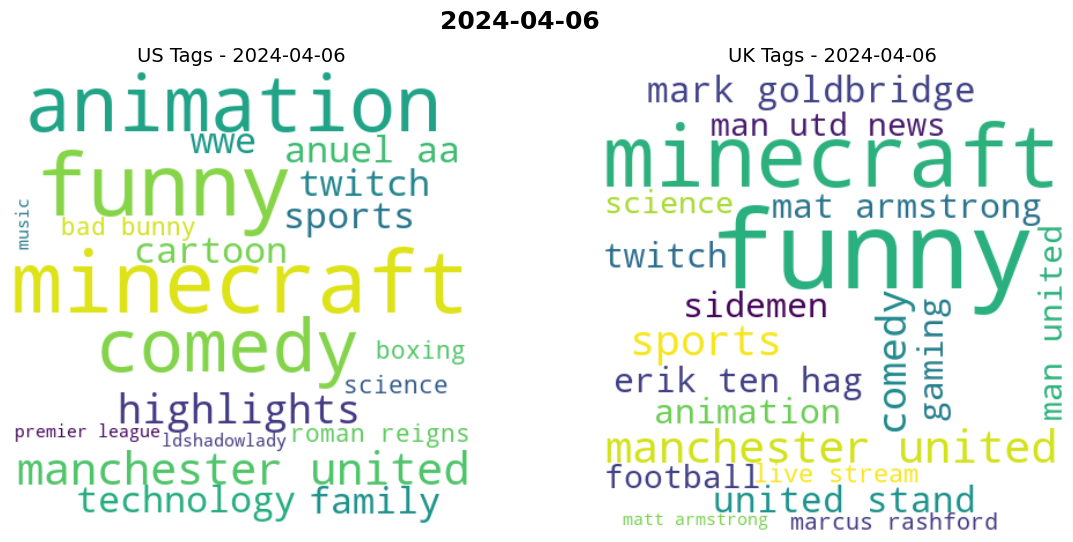

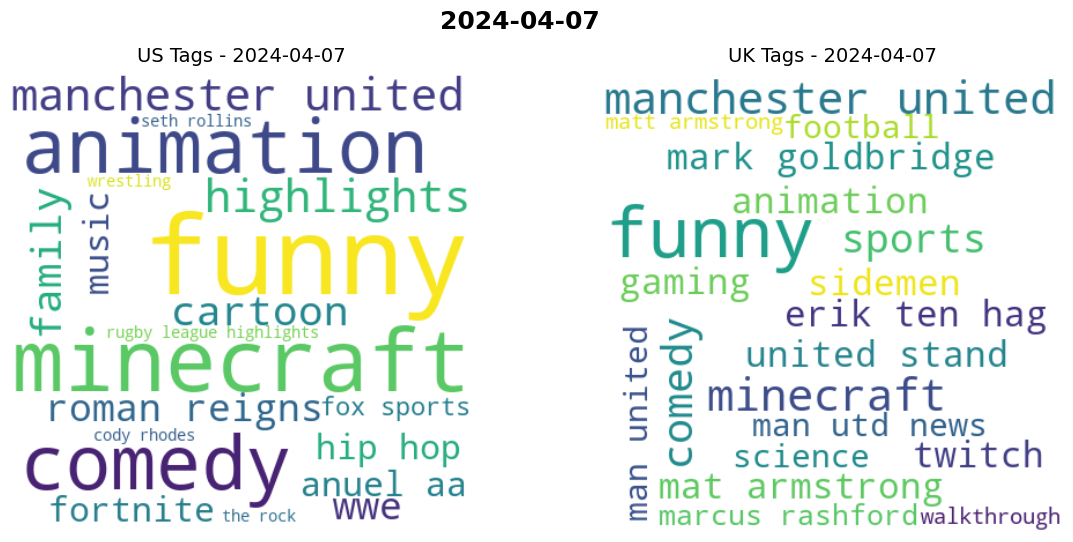

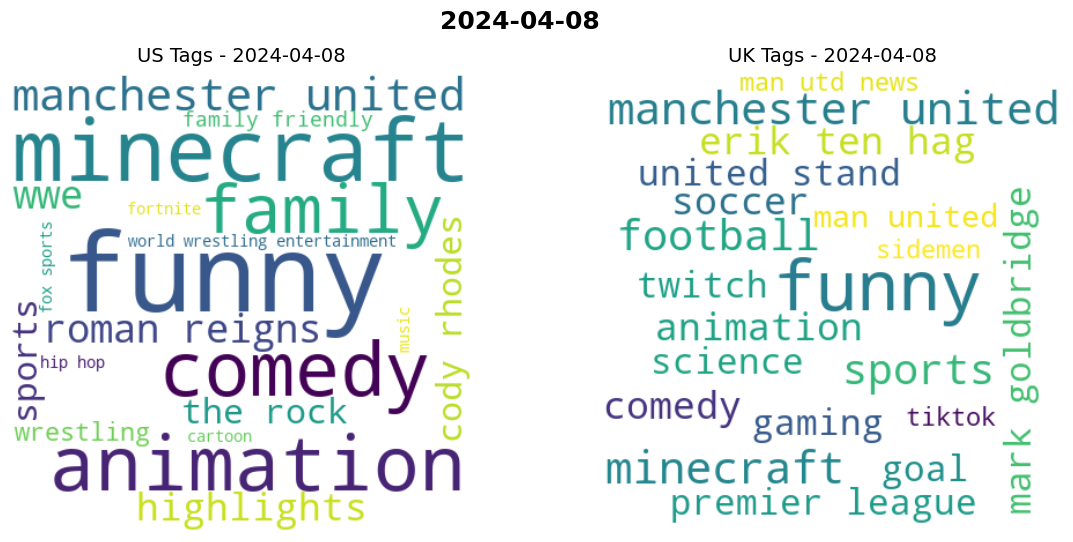

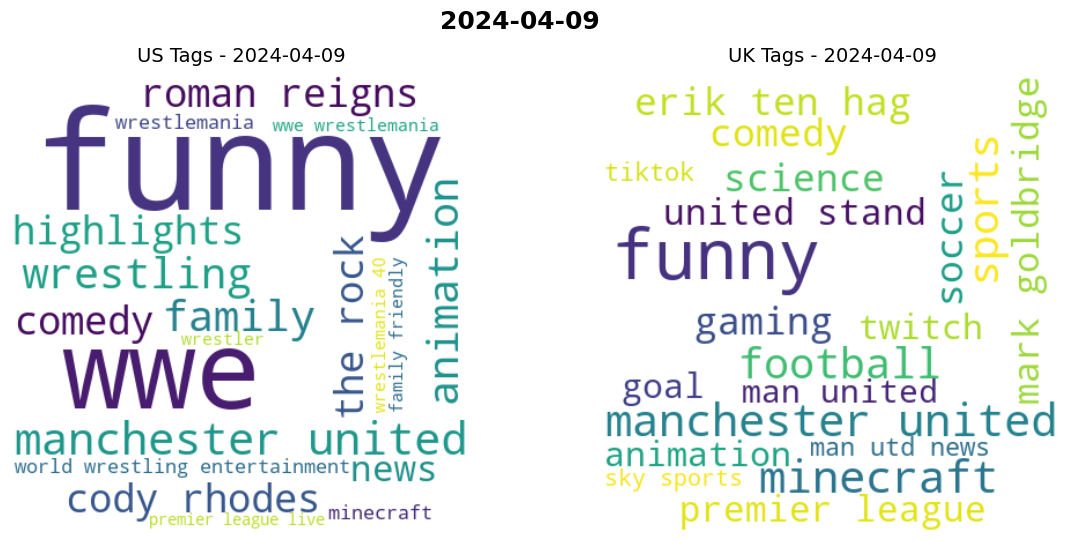

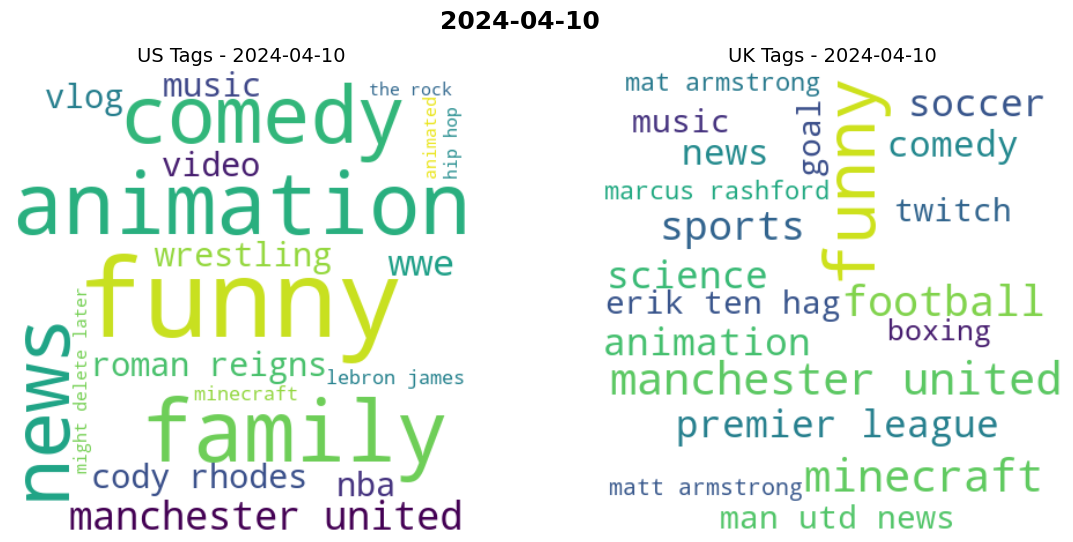

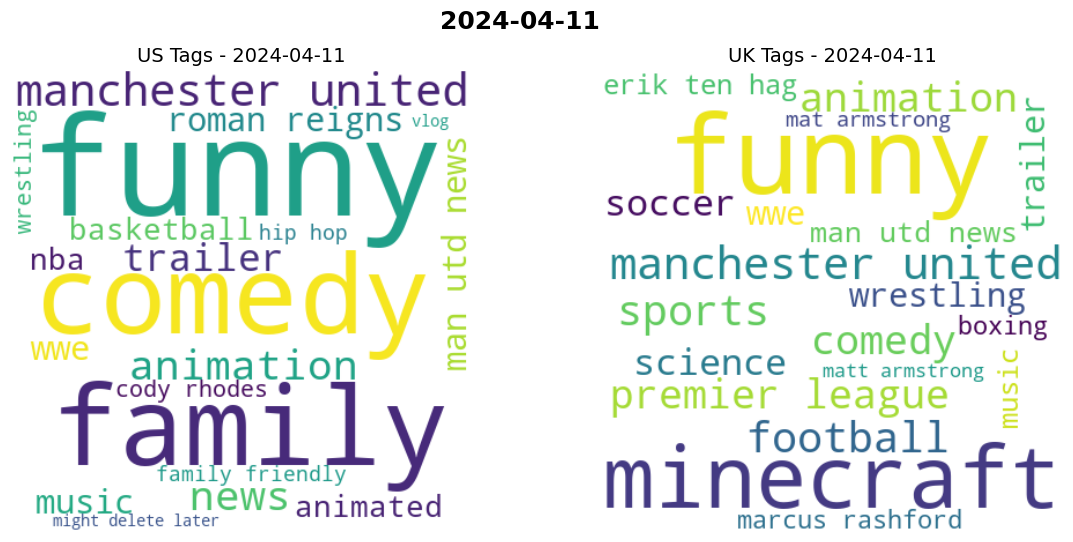

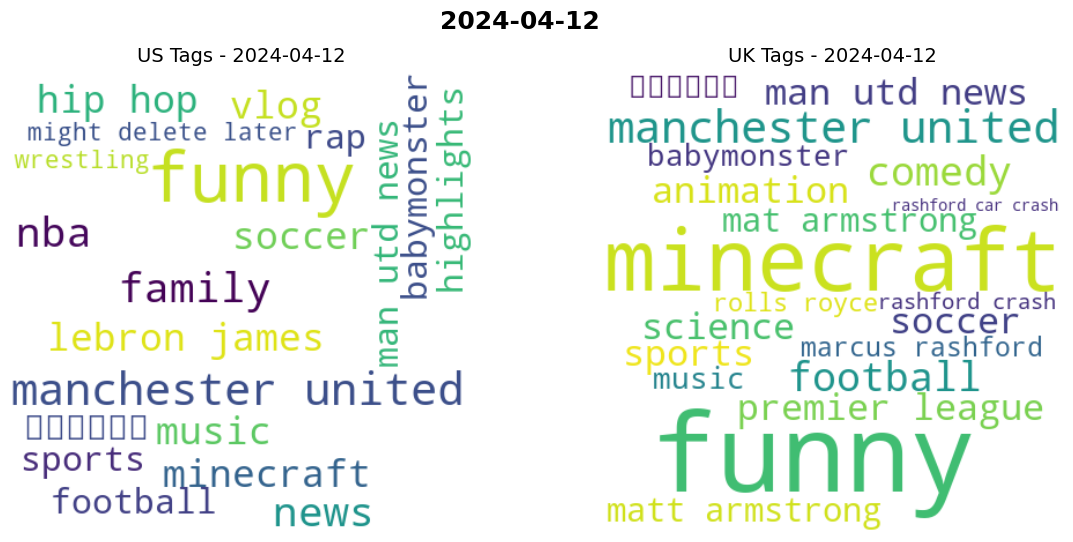

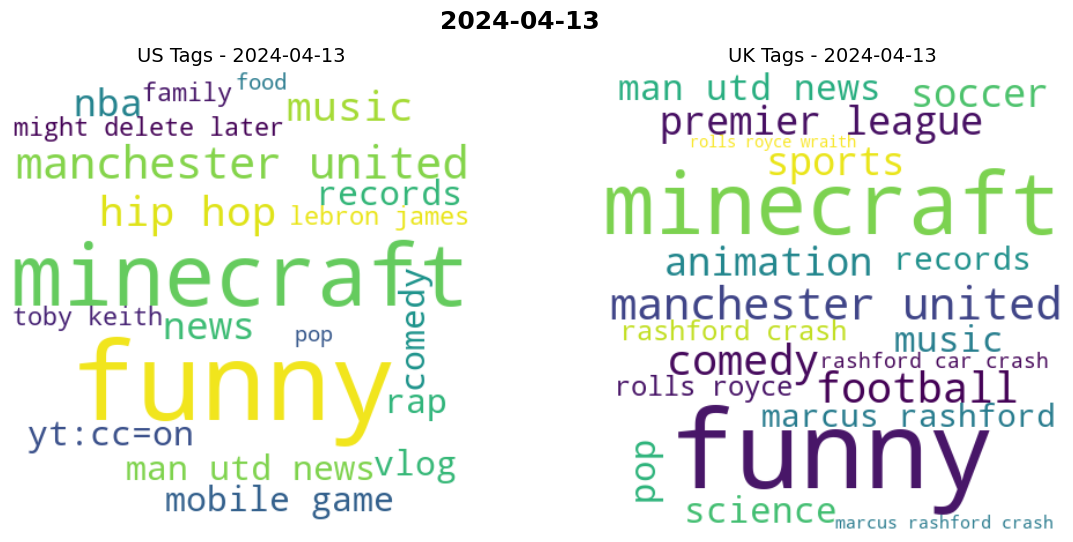

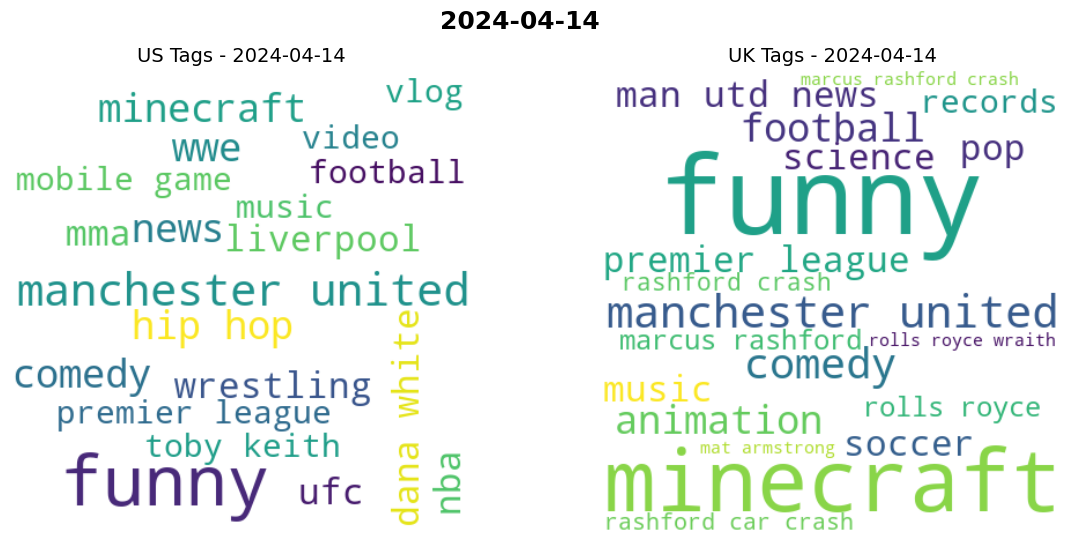

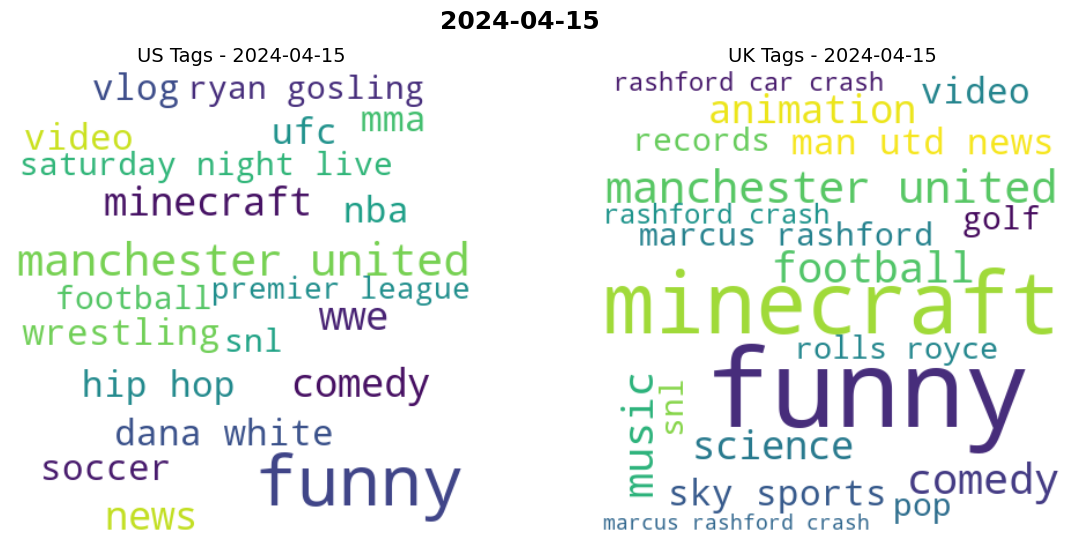

In [58]:
unique_dates = get_unique_dates_in_chronological_order(videosUS, videosUK)

# Last ten days captured in the datasets
generate_daily_word_clouds(unique_dates[-10:], videosUS, videosUK, n=20)

# P-values

In [92]:
from scipy.stats import binomtest

def test_video_exclusivity(videos_country_only, videos_other_country, hypothesized_proportion=0.5):
    # Calculate counts
    exclusive_count = len(videos_country_only)
    total_count = exclusive_count + len(videos_other_country)
    
    if total_count == 0:
        raise ValueError("No videos to test. Please check the input data.")

    # Conduct binomial test
    result = binomtest(
        k=exclusive_count,  # Number of exclusive videos
        n=total_count,      # Total videos
        p=hypothesized_proportion,  # Null hypothesis proportion
        alternative='two-sided'     # Test for significant deviation
    )
    
    return {
        "exclusive_count": exclusive_count,
        "total_count": total_count,
        "observed_proportion": exclusive_count / total_count,
        "p_value": result.pvalue
    }

# Apply the test for videos trending only in US
us_exclusivity_result = test_video_exclusivity(us_only, noduplUK)
print("\nUS Exclusivity Test Results:")
print(f"Exclusive Count: {us_exclusivity_result['exclusive_count']}")
print(f"Total Count: {us_exclusivity_result['total_count']}")
print(f"Observed Proportion: {us_exclusivity_result['observed_proportion']:.4f}")
print(f"P-Value: {us_exclusivity_result['p_value']}")

# Apply the test for videos trending only in UK
uk_exclusivity_result = test_video_exclusivity(uk_only, noduplUS)
print("\nUK Exclusivity Test Results:")
print(f"Exclusive Count: {uk_exclusivity_result['exclusive_count']}")
print(f"Total Count: {uk_exclusivity_result['total_count']}")
print(f"Observed Proportion: {uk_exclusivity_result['observed_proportion']:.4f}")
print(f"P-Value: {uk_exclusivity_result['p_value']}")



US Exclusivity Test Results:
Exclusive Count: 7101
Total Count: 54708
Observed Proportion: 0.1298
P-Value: 0.0

UK Exclusivity Test Results:
Exclusive Count: 8436
Total Count: 55578
Observed Proportion: 0.1518
P-Value: 0.0


In [94]:
# Apply the test for videos trending in US (but possibly both countries)
us_exclusivity_result = test_video_exclusivity(noduplUS, noduplUK)
print("\nUS All Videos Test Results:")
print(f"Exclusive Count: {us_exclusivity_result['exclusive_count']}")
print(f"Total Count: {us_exclusivity_result['total_count']}")
print(f"Observed Proportion: {us_exclusivity_result['observed_proportion']:.4f}")
print(f"P-Value: {us_exclusivity_result['p_value']}")

# Apply the test for videos trending in UK (but possibly both countries)
uk_exclusivity_result = test_video_exclusivity(noduplUK, noduplUS)
print("\nUK All Videos Test Results:")
print(f"Exclusive Count: {uk_exclusivity_result['exclusive_count']}")
print(f"Total Count: {uk_exclusivity_result['total_count']}")
print(f"Observed Proportion: {uk_exclusivity_result['observed_proportion']:.4f}")
print(f"P-Value: {uk_exclusivity_result['p_value']}")


US All Videos Test Results:
Exclusive Count: 47142
Total Count: 94749
Observed Proportion: 0.4975
P-Value: 0.13170581318447871

UK All Videos Test Results:
Exclusive Count: 47607
Total Count: 94749
Observed Proportion: 0.5025
P-Value: 0.13170581318447871


In [107]:
categ_prevalent_in_1_country = []

for catego in [1,2,10,15,17,19,20,22,23,24,25,26,27,28]:
    print(categDict[str(catego)].upper() )
    print()
    
    us_exclusivity_result = test_video_exclusivity(noduplUS[noduplUS["categoryId"] == catego], noduplUK[noduplUK["categoryId"] == catego])
    uk_exclusivity_result = test_video_exclusivity(noduplUK[noduplUK["categoryId"] == catego], noduplUS[noduplUS["categoryId"] == catego])
    print(f"US Exclusive Count: {us_exclusivity_result['exclusive_count']}")
    print(f"UK Exclusive Count: {uk_exclusivity_result['exclusive_count']}")
    print(f"Total Count: {us_exclusivity_result['total_count']}")
    print(f"US Observed Proportion: {us_exclusivity_result['observed_proportion']:.4f}")
    print(f"UK Observed Proportion: {uk_exclusivity_result['observed_proportion']:.4f}")
    print(f"P-Value: {us_exclusivity_result['p_value']}")
    if (us_exclusivity_result['p_value'] <= 0.05):
        categ_prevalent_in_1_country.append(categDict[str(catego)])

    print()

print()
print(categ_prevalent_in_1_country)

FILM & ANIMATION

US Exclusive Count: 1837
UK Exclusive Count: 1349
Total Count: 3186
US Observed Proportion: 0.5766
UK Observed Proportion: 0.4234
P-Value: 5.3978049086670454e-18

AUTOS & VEHICLES

US Exclusive Count: 967
UK Exclusive Count: 1153
Total Count: 2120
US Observed Proportion: 0.4561
UK Observed Proportion: 0.5439
P-Value: 5.811380463622482e-05

MUSIC

US Exclusive Count: 7351
UK Exclusive Count: 5754
Total Count: 13105
US Observed Proportion: 0.5609
UK Observed Proportion: 0.4391
P-Value: 2.7772064714724323e-44

PETS & ANIMALS

US Exclusive Count: 207
UK Exclusive Count: 192
Total Count: 399
US Observed Proportion: 0.5188
UK Observed Proportion: 0.4812
P-Value: 0.4834268170591438

SPORTS

US Exclusive Count: 6073
UK Exclusive Count: 9696
Total Count: 15769
US Observed Proportion: 0.3851
UK Observed Proportion: 0.6149
P-Value: 1.4608587295762179e-184

TRAVEL & EVENTS

US Exclusive Count: 292
UK Exclusive Count: 445
Total Count: 737
US Observed Proportion: 0.3962
UK Observed